In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

In [2]:
gDNA_c_file = '/project2/kribelba_1515/saadawy/barcode_gDNA_counts.tsv'
mRNA_c_file = '/project2/kribelba_1515/saadawy/barcode_mRNA_counts.tsv'
data_path = '/project2/kribelba_1515/data/EXTRA_seq/2024_data/uniEXTRA_lib6p0/barcode23_6p0uniExtraHub4p75_mapping_nanopore.tsv'
mapping = pd.read_csv(data_path, sep='\t')
gDNA_counts = pd.read_csv(gDNA_c_file, sep='\t')
mRNA_counts = pd.read_csv(mRNA_c_file, sep='\t')
barcode_counts = pd.merge(gDNA_counts, mRNA_counts)
for i in range(1, 6): # looping over the replicate columns
 gDNA_col = f"gDNA_rep{i}"
 mRNA_col = f"mRNA_rep{i}"
    
# If gDNA is 0 but mRNA is positive, set mRNA to 0
 barcode_counts.loc[barcode_counts[gDNA_col] == 0, mRNA_col] = 0
replicate_columns = ['gDNA_rep1', 'gDNA_rep2', 'gDNA_rep3', 'gDNA_rep4', 'gDNA_rep5']
replicate_columns_mRNA = ['mRNA_rep1', 'mRNA_rep2', 'mRNA_rep3', 'mRNA_rep4', 'mRNA_rep5']

# compute total counts per barcode
barcode_counts['gDNA_Counts'] = barcode_counts[replicate_columns].sum(axis=1)
barcode_counts['mRNA_Counts'] = barcode_counts[replicate_columns_mRNA].sum(axis=1)
barcode_counts['mRNA/gDNA'] = barcode_counts['mRNA_Counts'] / barcode_counts['gDNA_Counts']

# how many replicates contribute to the total
barcode_counts['nonzero_replicates'] = (barcode_counts[replicate_columns] > 0).sum(axis=1)

In [3]:
valid_chars = {'A', 'T', 'G', 'C'}

def clean_mapping(df):
 if 'Read_name' in df.columns:
  df.drop('Read_name', inplace=True, axis=1)
 mapping = df.rename(columns={'Reference': 'Enhancer_ID','BC_sequence': 'Enhancer_Seq', 'TF_sequence': 'Barcode_Seq'})
 mapping = mapping.dropna(subset=['Barcode_Seq'])  # remove any NaN barcodes
 mapping = mapping[
    (mapping['Barcode_Seq'].str.len() == 12) & 
    (mapping['Barcode_Seq'].apply(lambda x: set(x).issubset(valid_chars)))]
 return mapping
mapping = clean_mapping(mapping)

In [4]:
def process_mapping(df):
 # count occurrences of each barcode per Enhancer_ID
 barcode_mapping_counts = df.groupby(['Barcode_Seq', 'Enhancer_ID']).size().reset_index(name='count') # pivot without enhancer_seq

 # this is just pivotting as Excel, where rows are barcodes, columns are Enhancer_IDs, and values are group counts
 mapping_df = barcode_mapping_counts.pivot_table(index='Barcode_Seq', 
                                       columns='Enhancer_ID', 
                                       values='count', 
                                       fill_value=0)
 mapping_df = mapping_df.reset_index()
 mapping_df.columns.name = None

 numeric_cols = mapping_df.columns[1:]
 # summing the count of barcodes across all enhancer_ids
 mapping_df['Mapping_Counts'] = mapping_df[numeric_cols].sum(axis=1)

 # find the enhancer_id with the highest count for each barcode
 mapping_df['Max_Mapping_Count'] = mapping_df[numeric_cols].max(axis=1)

 # the second maximum count to use it in the max/second max ratio later
 mapping_df['Second_Max_Mapping_Count'] = mapping_df[numeric_cols].apply(lambda row: sorted(row, reverse=True)[1], axis=1)

 # calculate ratio (avoid division by zero by assigning infinity to uniquely mapped barcode)
 mapping_df['Mapping_Ratio'] = np.where(
        mapping_df['Second_Max_Mapping_Count'] > 0, 
        mapping_df['Max_Mapping_Count'] / mapping_df['Second_Max_Mapping_Count'], 
        np.inf
    )

 # find the enhancer_id with the max count
 mapping_df['Enhancer'] = mapping_df[numeric_cols].idxmax(axis=1)

 mapping_df = mapping_df[['Barcode_Seq', 'Mapping_Counts', 'Mapping_Ratio', 'Enhancer']]
 return mapping_df

mapping_df = process_mapping(mapping)

In [5]:
ratio_thresholds = [2, 3, 4]
total_gDNA_thresholds = [10, 50, 100]

results = []
final = {} # dict containing all filter schemes

for ratio_thresh in ratio_thresholds:
    for total_gDNA_thresh in total_gDNA_thresholds:
        mapped_barcode_counts = pd.merge(
            barcode_counts, mapping_df, 
            left_on='sequence', right_on='Barcode_Seq', how='inner'
        )
        mapped_barcode_counts.drop(columns=['Barcode_Seq'], inplace=True)

        mapped_barcode_counts_filtered = mapped_barcode_counts[
        (mapped_barcode_counts['gDNA_Counts'] >= total_gDNA_thresh) &
         (mapped_barcode_counts['nonzero_replicates'] >= 3) &
        (mapped_barcode_counts['Mapping_Ratio'] >= ratio_thresh) # filter those having gDNA counts above a certain threshold (and that threshold must come from 3 different replicates),
        # but if that threshold is less than 3, don't filter based on that scheme
]

        mapped_barcode_counts_filtered['Enhancer'] = mapped_barcode_counts_filtered['Enhancer'].str.replace(r'_\d$', '', regex=True)
        intersected_count = len(mapped_barcode_counts_filtered)
        results.append((ratio_thresh, total_gDNA_thresh, intersected_count))
        final[(ratio_thresh, total_gDNA_thresh)] = mapped_barcode_counts_filtered[['sequence', 'gDNA_Counts', 'mRNA_Counts', 'mRNA/gDNA', 'Mapping_Counts', 'Mapping_Ratio', 'Enhancer']]

results_df = pd.DataFrame(results, columns=['Ratio_Threshold', 'Total_gDNA_Counts_Threshold', 'Intersected_Barcodes'])
df = final[(2, 10)].copy()
final_df = final[(2, 100)]

/tmp/SLURM_1403151/ipykernel_3513904/2764755299.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_barcode_counts_filtered['Enhancer'] = mapped_barcode_counts_filtered['Enhancer'].str.replace(r'_\d$', '', regex=True)
/tmp/SLURM_1403151/ipykernel_3513904/2764755299.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_barcode_counts_filtered['Enhancer'] = mapped_barcode_counts_filtered['Enhancer'].str.replace(r'_\d$', '', regex=True)
/tmp/SLURM_1403151/ipykernel_3513904/2764755299.py:22: Setti

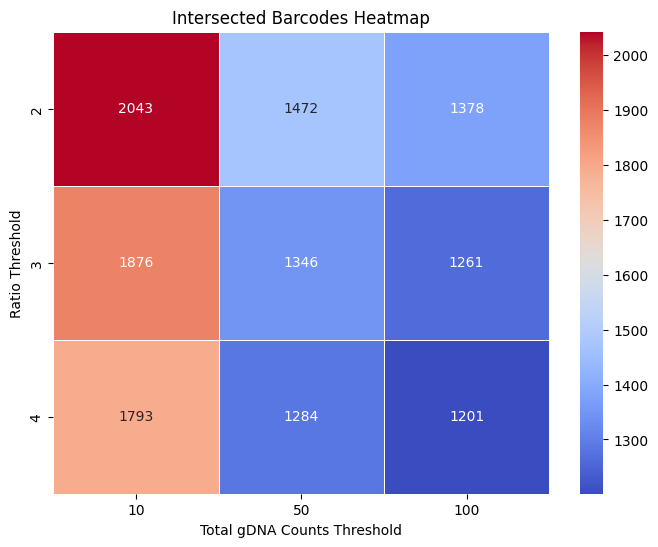

In [153]:
# heatmap showing the intersected number of barcodes across different filter schemes
heatmap_data = results_df.pivot(index="Ratio_Threshold", columns="Total_gDNA_Counts_Threshold", values="Intersected_Barcodes")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5)

plt.xlabel("Total gDNA Counts Threshold")
plt.ylabel("Ratio Threshold")
plt.title("Intersected Barcodes Heatmap")

plt.show()

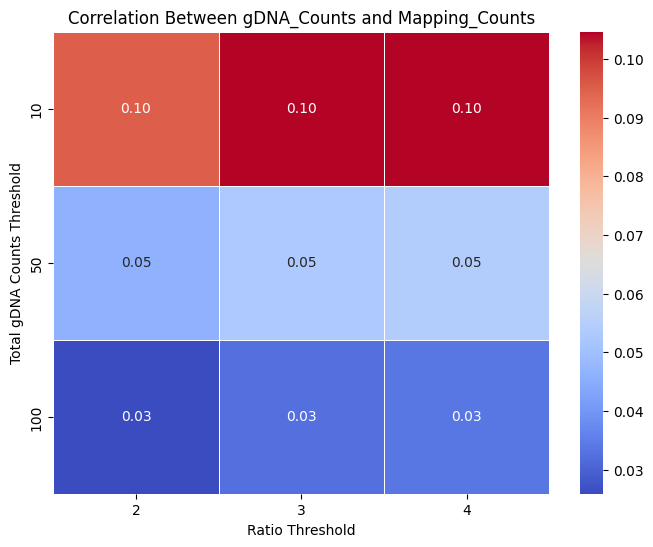

In [154]:
# correlation between gDNA_Counts and Nanopore Mapping_Counts
correlation_results = []

for (ratio_thresh, total_gDNA_thresh), df in final.items():
    if not df.empty:
        correlation, p_value = stats.pearsonr(df['gDNA_Counts'], df['Mapping_Counts'])
        correlation_results.append((ratio_thresh, total_gDNA_thresh, correlation, p_value))
    else:
        correlation_results.append((ratio_thresh, total_gDNA_thresh, None, None))

correlation_df = pd.DataFrame(correlation_results, columns=['Ratio_Threshold', 'Total_gDNA_Counts_Threshold', 'Correlation', 'P_Value'])

significant_correlations = correlation_df[correlation_df['P_Value'] < 0.05]

heatmap_data = correlation_df.pivot(index="Total_gDNA_Counts_Threshold", columns="Ratio_Threshold", values="Correlation")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between gDNA_Counts and Mapping_Counts")
plt.xlabel("Ratio Threshold")
plt.ylabel("Total gDNA Counts Threshold")
plt.show()

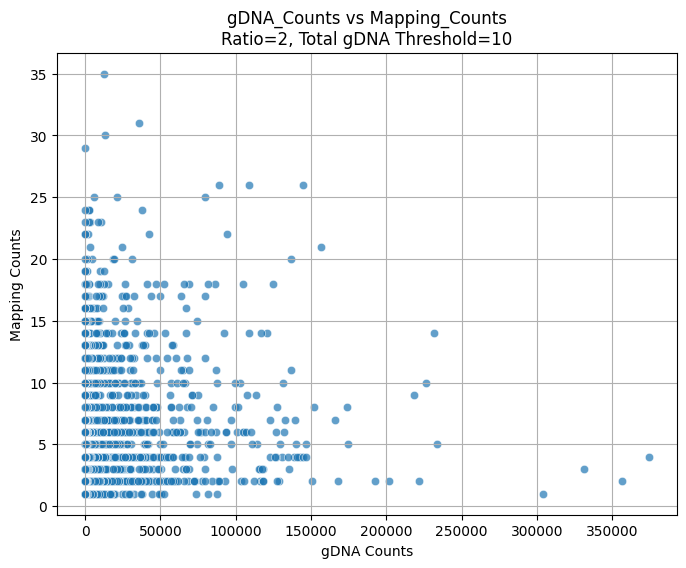

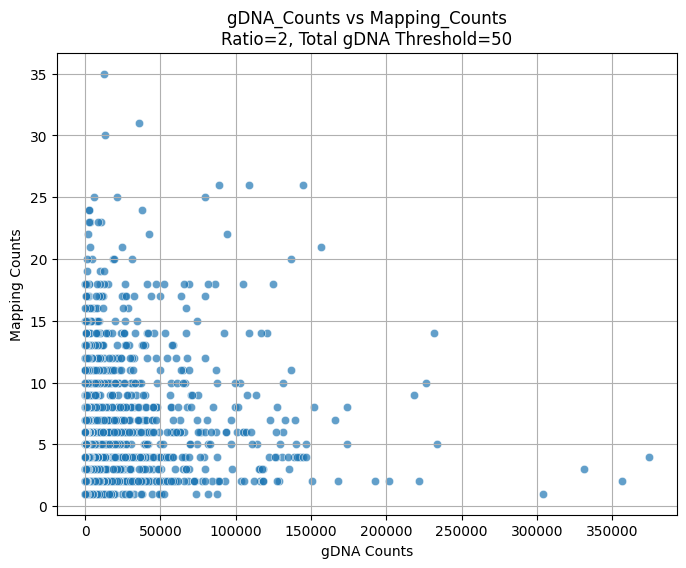

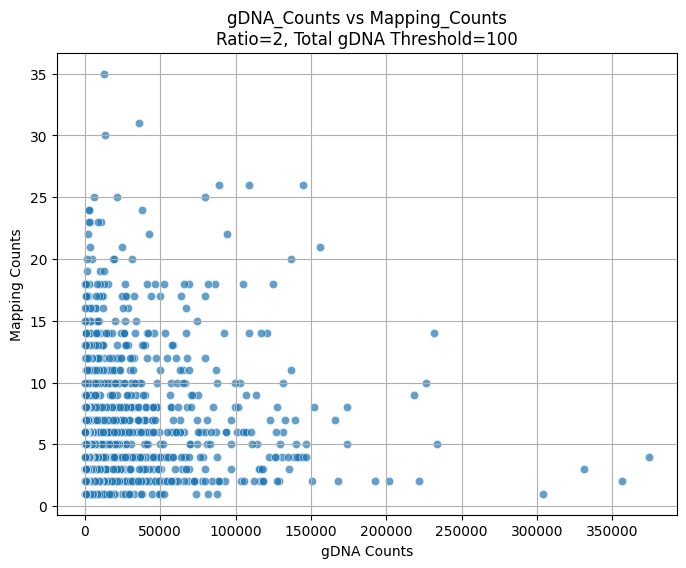

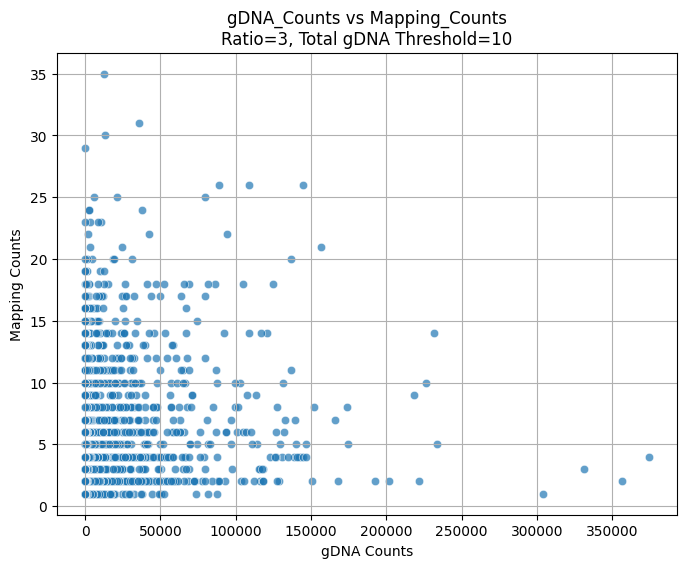

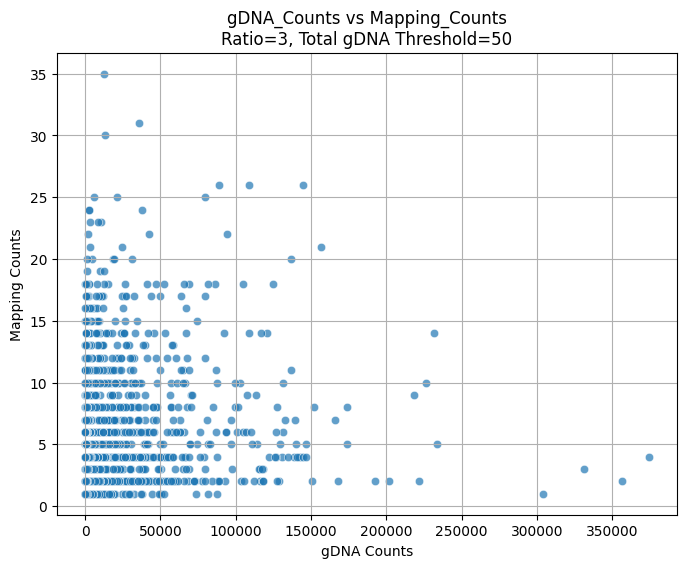

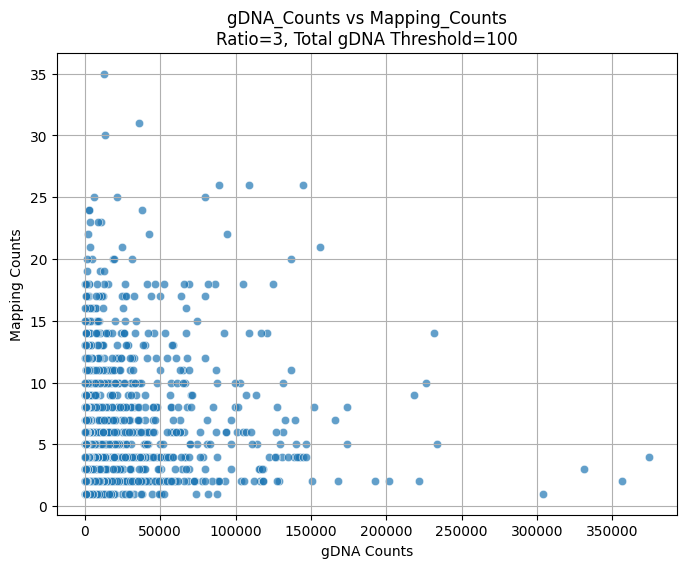

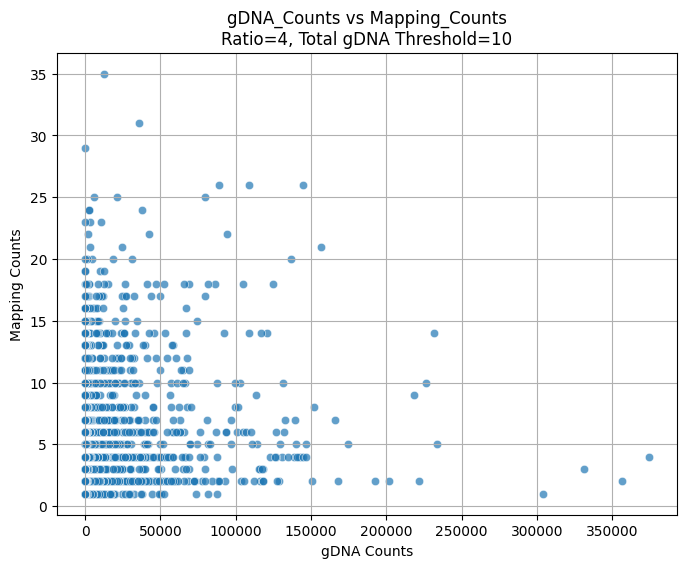

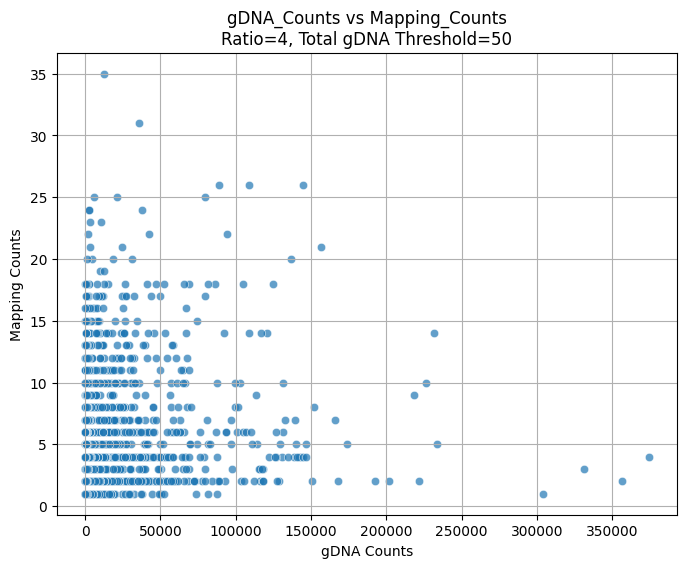

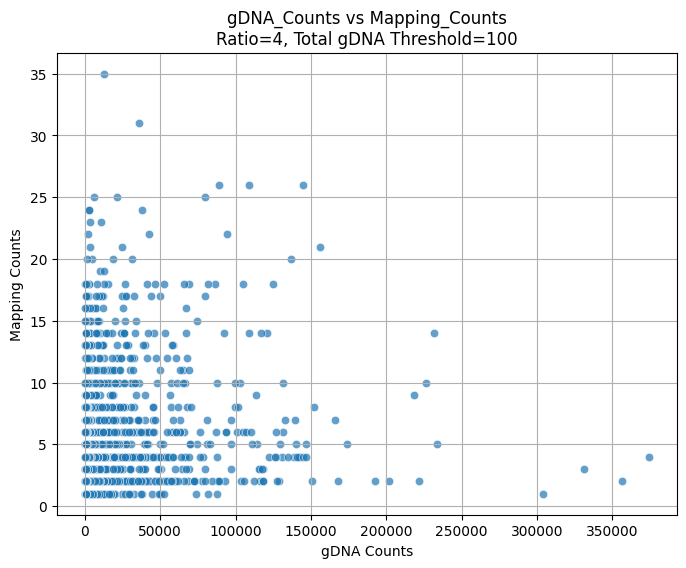

In [155]:
# scatter plot between gDNA_Counts and Nanopore Mapping_Counts
for (ratio_thresh, total_gDNA_thresh), df in final.items():
    plt.figure(figsize=(8, 6))
    
    sns.scatterplot(x=df['gDNA_Counts'], y=df['Mapping_Counts'], alpha=0.7)
    
    plt.title(f"gDNA_Counts vs Mapping_Counts\nRatio={ratio_thresh}, Total gDNA Threshold={total_gDNA_thresh}")
    plt.xlabel("gDNA Counts")
    plt.ylabel("Mapping Counts")
    
    plt.grid(True)
    
    plt.show()

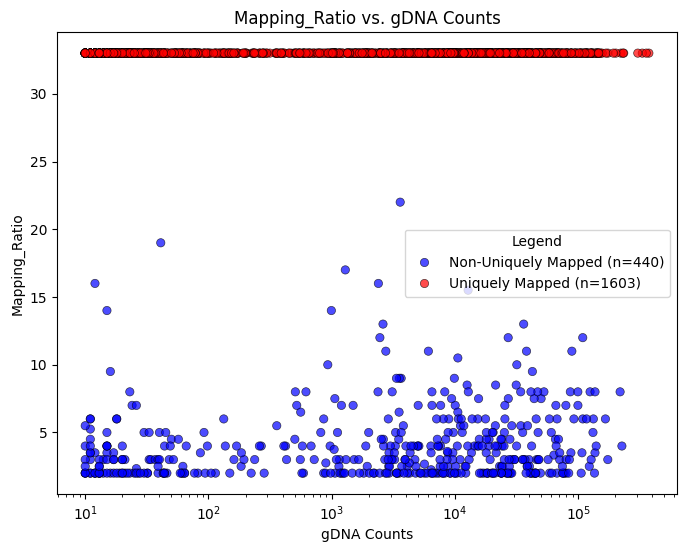

In [236]:
# plot between Ratio and gDNA_Counts
max_ratio = df[np.isfinite(df["Mapping_Ratio"])]["Mapping_Ratio"].max()
df["Mapping_Ratio"] = df["Mapping_Ratio"].replace(np.inf, max_ratio * 1.5)

df["is_inf_replaced"] = df["Mapping_Ratio"] == max_ratio * 1.5

counts = df["is_inf_replaced"].value_counts()
labels = {
    False: f"Non-Uniquely Mapped (n={counts.get(False, 0)})",
    True: f"Uniquely Mapped (n={counts.get(True, 0)})"
}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, 
    x="gDNA_Counts", 
    y="Mapping_Ratio", 
    hue="is_inf_replaced",
    palette={False: "blue", True: "red"},
    edgecolor="black",
    alpha=0.7
)

plt.xscale("log")
# plt.yscale("log")
plt.xlabel("gDNA Counts")
plt.ylabel("Mapping_Ratio")
plt.title("Mapping_Ratio vs. gDNA Counts")

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, [labels[False], labels[True]], title="Legend", loc="best")

plt.show()

In [157]:
# code to take the union of barcodes across different filter schemes, 
# and for each barcode associate it with a set of 1's and 0's 
# corresponding to whether this barcode was found across that filter scheme or not
# e.g. barcode x --> [1, 0, 0, 0, 1, 1, 0] meaning it is selected across filter 1, 5, and 6 only... and so on for all barcodes.


ratio_thresholds = [2, 3, 4]
total_gDNA_thresholds = [10, 50, 100]

combination_results = {}

for ratio_thresh in ratio_thresholds:
    for total_gDNA_thresh in total_gDNA_thresholds:
        mapped_barcode_counts = pd.merge(
            barcode_counts, mapping_df, 
            left_on='sequence', right_on='Barcode_Seq', how='inner'
        )
        mapped_barcode_counts.drop(columns=['Barcode_Seq'], inplace=True)
        
        mapped_barcode_counts_filtered = mapped_barcode_counts[
            (mapped_barcode_counts['gDNA_Counts'] >= total_gDNA_thresh) &
            (mapped_barcode_counts['nonzero_replicates'] >= 3) &
            (mapped_barcode_counts['Mapping_Ratio'] >= ratio_thresh)
        ]
        
        combination_results[(ratio_thresh, total_gDNA_thresh)] = mapped_barcode_counts_filtered

all_unique_barcodes = pd.concat(combination_results.values()).drop_duplicates(subset=['sequence'])

final_df = all_unique_barcodes.copy()

for ratio_thresh in ratio_thresholds:
    for total_gDNA_thresh in total_gDNA_thresholds:
        col_name = f"Ratio_{ratio_thresh}_gDNA_{total_gDNA_thresh}"
        valid_sequences = set(combination_results[(ratio_thresh, total_gDNA_thresh)]['sequence'])
        final_df[col_name] = final_df['sequence'].apply(lambda x: 1 if x in valid_sequences else 0)
if 'nonzero_replicates' in final_df.columns:
 final_df.drop('nonzero_replicates', axis=1, inplace=True)
final_df['Enhancer'] = final_df['Enhancer'].str.replace(r'_\d$', '', regex=True)

In [159]:
# generic code to take the outer merge between the barcode with count data and Nanopore mapping data 
# to see barcodes that were uniquely mapped, non-uniquely mapped, and non-mapped to compare them.
ratio_thresholds = [2, 3, 4]
total_gDNA_thresholds = [10, 50, 100]

results2 = {}

for ratio_thresh in ratio_thresholds:
    for total_gDNA_thresh in total_gDNA_thresholds:
        # Perform an outer merge to keep all barcodes with gDNA counts
        mapped_barcode_counts = pd.merge(
            barcode_counts, mapping_df, 
            left_on='sequence', right_on='Barcode_Seq', how='left'
        )

        mapped_barcode_counts['Enhancer'].fillna(value='None', inplace=True)
        mapped_barcode_counts['Mapping_Ratio'].fillna(value=0, inplace=True)

        mapped_barcode_counts.drop(columns=['Barcode_Seq'], inplace=True)

        mapped_barcode_counts_filtered = mapped_barcode_counts[
        (mapped_barcode_counts['gDNA_Counts'] >= total_gDNA_thresh) &
        (mapped_barcode_counts['nonzero_replicates'] >= 3)
]        
        results2[(ratio_thresh, total_gDNA_thresh)] = mapped_barcode_counts_filtered[['sequence', 'gDNA_Counts', 'Mapping_Counts', 'Mapping_Ratio', 'Enhancer']]

/tmp/SLURM_1013496/ipykernel_1107797/2768671417.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mapped_barcode_counts['Enhancer'].fillna(value='None', inplace=True)
/tmp/SLURM_1013496/ipykernel_1107797/2768671417.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

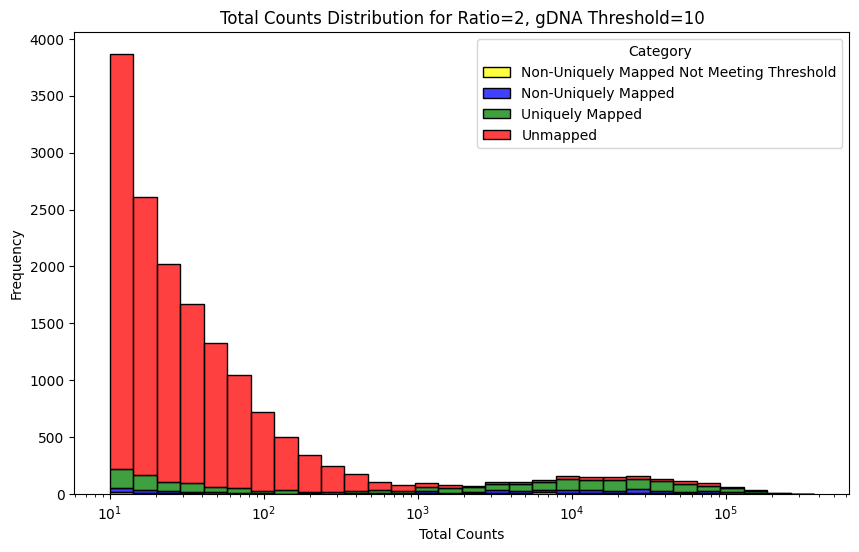

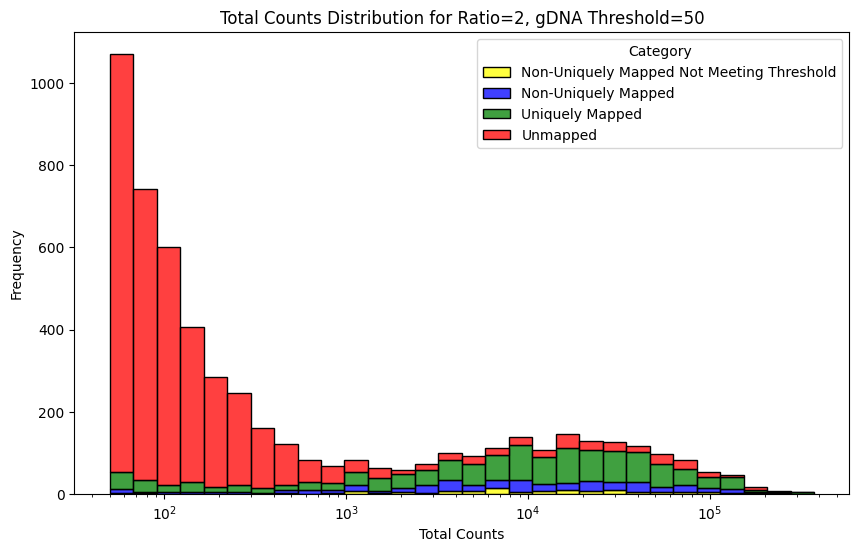

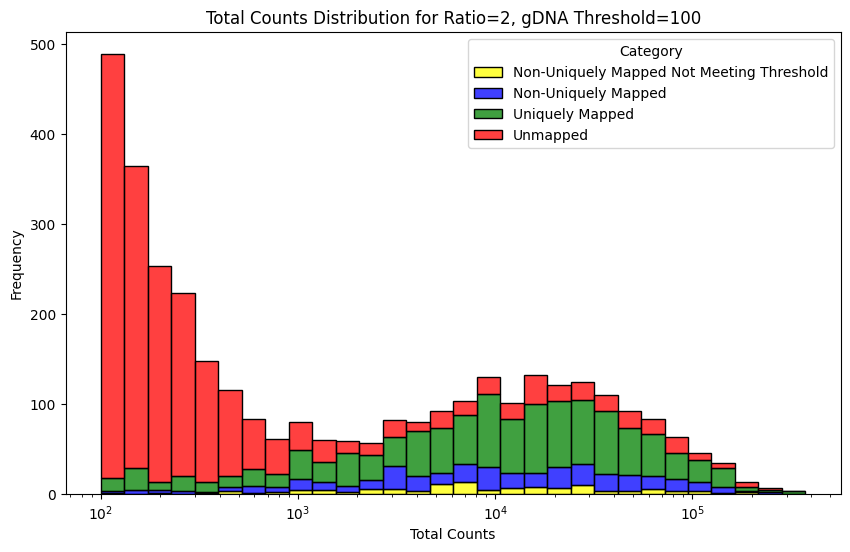

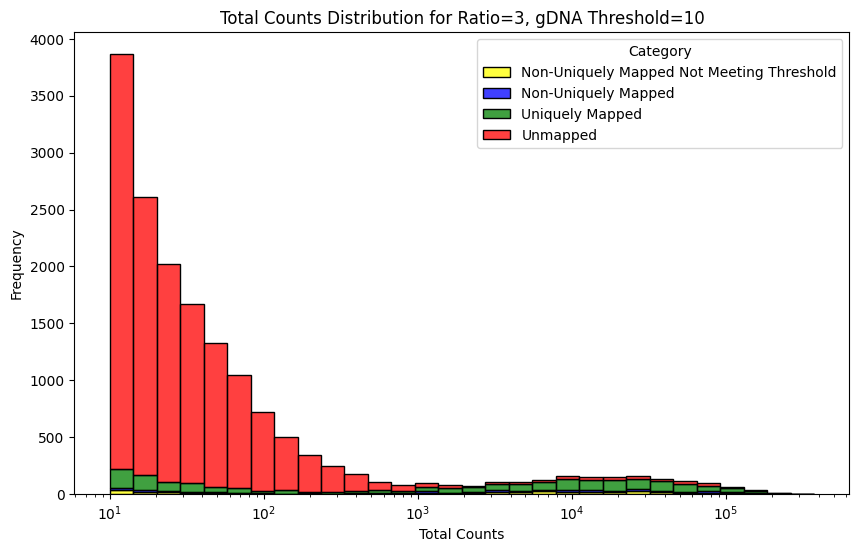

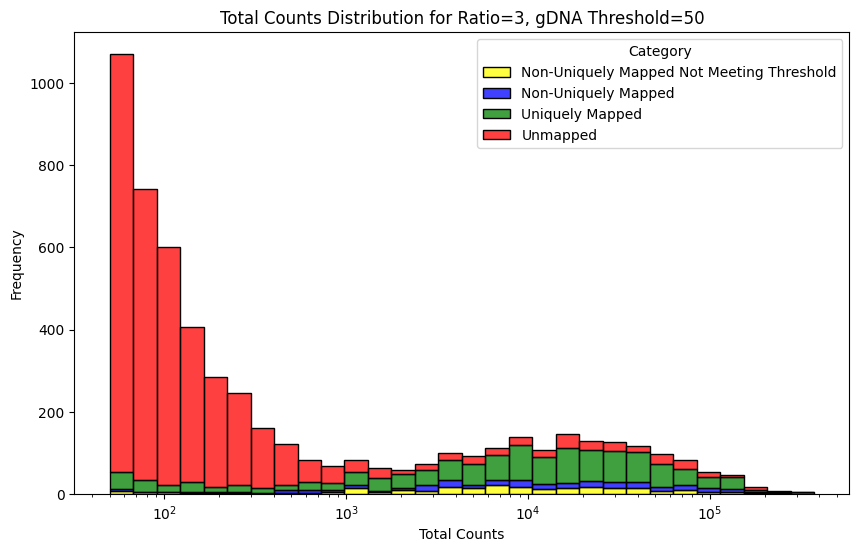

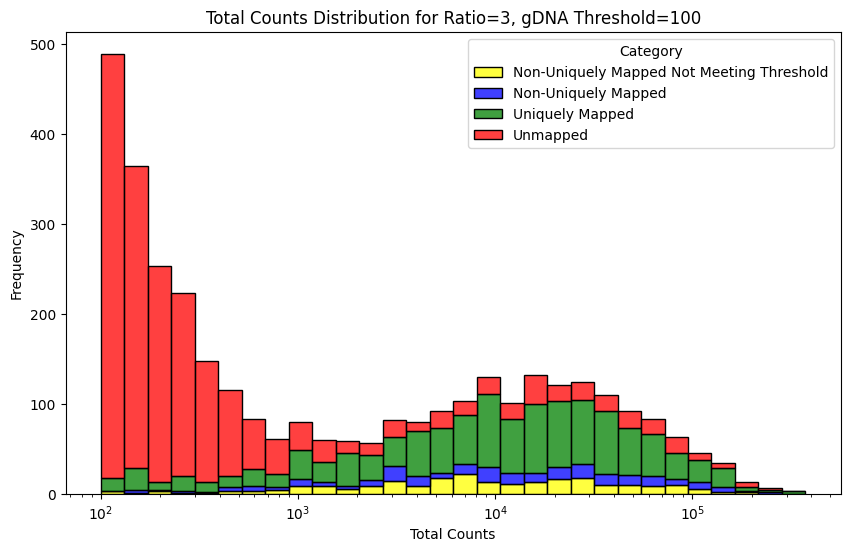

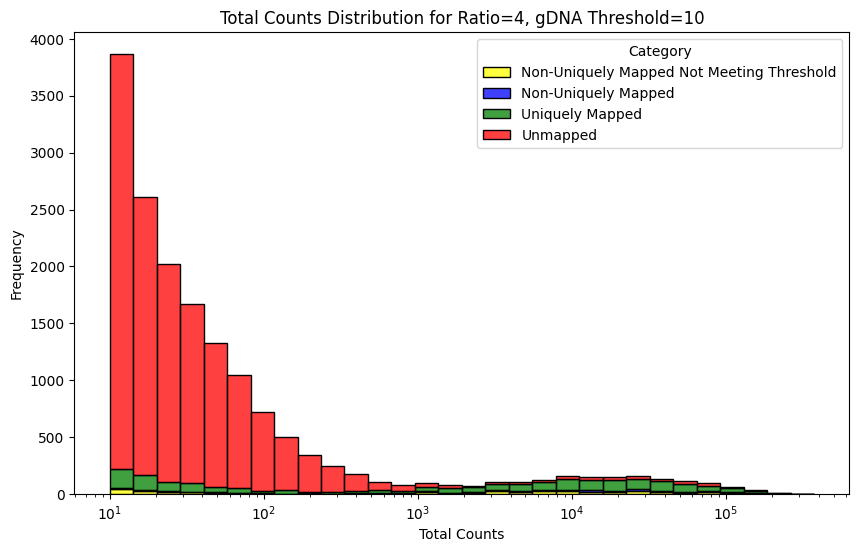

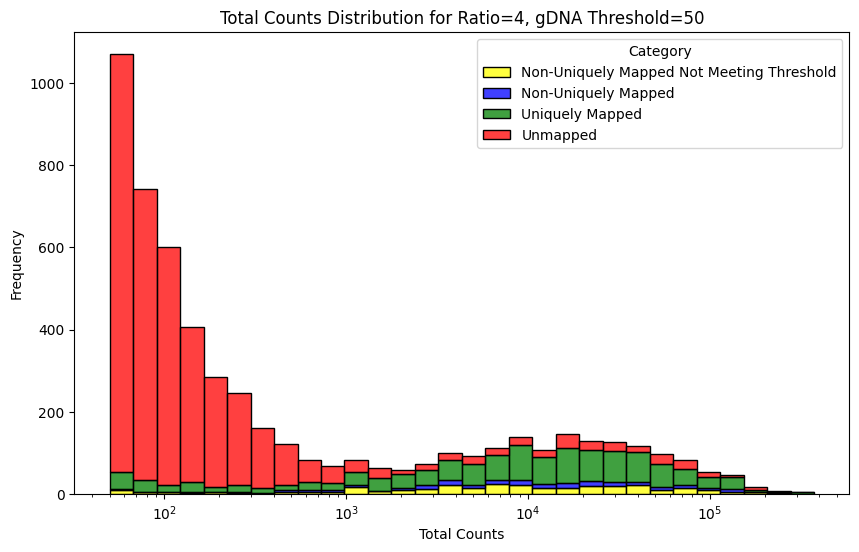

/tmp/SLURM_1013496/ipykernel_1107797/718529048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'] = df['Mapping_Ratio'].apply(lambda x:


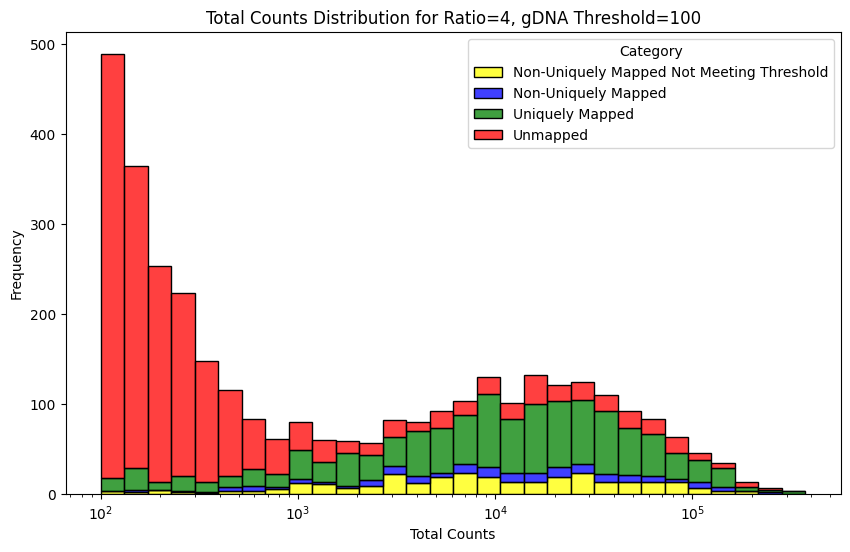

In [163]:
category_colors = {
        'Unmapped': 'red',     
        'Uniquely Mapped': 'green',    
        'Non-Uniquely Mapped': 'blue',
        'Non-Uniquely Mapped Not Meeting Threshold': 'yellow'
    }
hue_order = ['Unmapped', 'Uniquely Mapped', 'Non-Uniquely Mapped', 'Non-Uniquely Mapped Not Meeting Threshold']
for (ratio_thresh, total_gDNA_thresh), df in results2.items():
    df['Category'] = df['Mapping_Ratio'].apply(lambda x: 
    'Unmapped' if x == 0 else 
    ('Uniquely Mapped' if x == float('inf') else 
    ('Non-Uniquely Mapped' if x >= ratio_thresh else 
    'Non-Uniquely Mapped Not Meeting Threshold')))
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x='gDNA_Counts', hue='Category', kde=False, bins=30, log_scale=True, palette=category_colors, hue_order = hue_order, multiple='stack')
    plt.title(f'Total Counts Distribution for Ratio={ratio_thresh}, gDNA Threshold={total_gDNA_thresh}')
    plt.xlabel('Total Counts')
    plt.ylabel('Frequency')
    plt.legend(title='Category', labels=['Non-Uniquely Mapped Not Meeting Threshold', 'Non-Uniquely Mapped','Uniquely Mapped', 'Unmapped'])
    plt.show()

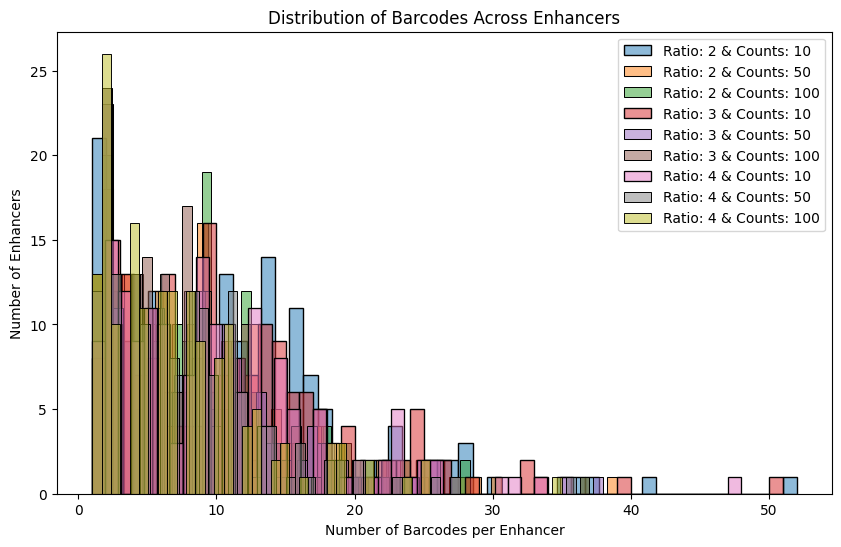

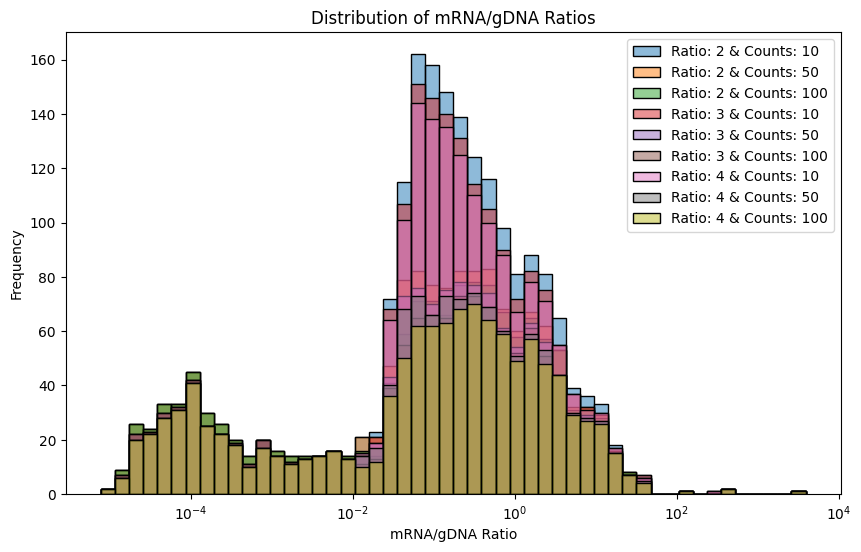

In [164]:
# Histogram distribution of barcodes across enhancers and distribution of mRNA/gDNA ratios

enhancer_counts_dict = {}
mRNA_gDNA_ratios = {}

for (ratio_thresh, total_gDNA_thresh), df in final.items():
    if total_gDNA_thresh == 1:
        continue
    merged_df = pd.merge(barcode_counts, df)
    merged_df.drop('nonzero_replicates', axis=1, errors='ignore', inplace=True)
    merged_df['Enhancer'] = merged_df['Enhancer'].str.replace(r'_\d$', '', regex=True)
    
    enhancer_counts_dict[(ratio_thresh, total_gDNA_thresh)] = merged_df['Enhancer'].value_counts()
    mRNA_gDNA_ratios[(ratio_thresh, total_gDNA_thresh)] = merged_df['mRNA/gDNA']

plt.figure(figsize=(10, 6))
for (ratio_thresh, total_gDNA_thresh), counts in enhancer_counts_dict.items():
    sns.histplot(counts, bins=50, alpha=0.5, label=f"Ratio: {ratio_thresh} & Counts: {total_gDNA_thresh}", log_scale=False, multiple='stack')

plt.xlabel("Number of Barcodes per Enhancer")
plt.ylabel("Number of Enhancers")
plt.title("Distribution of Barcodes Across Enhancers")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for (ratio_thresh, total_gDNA_thresh), ratios in mRNA_gDNA_ratios.items():
    sns.histplot(ratios, bins=50, log_scale=True, alpha=0.5, label=f"Ratio: {ratio_thresh} & Counts: {total_gDNA_thresh}", multiple='stack')

plt.xlabel('mRNA/gDNA Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of mRNA/gDNA Ratios')
plt.legend()
plt.show()

/tmp/SLURM_1013496/ipykernel_1107797/2570725992.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/SLURM_1013496/ipykernel_1107797/2570725992.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


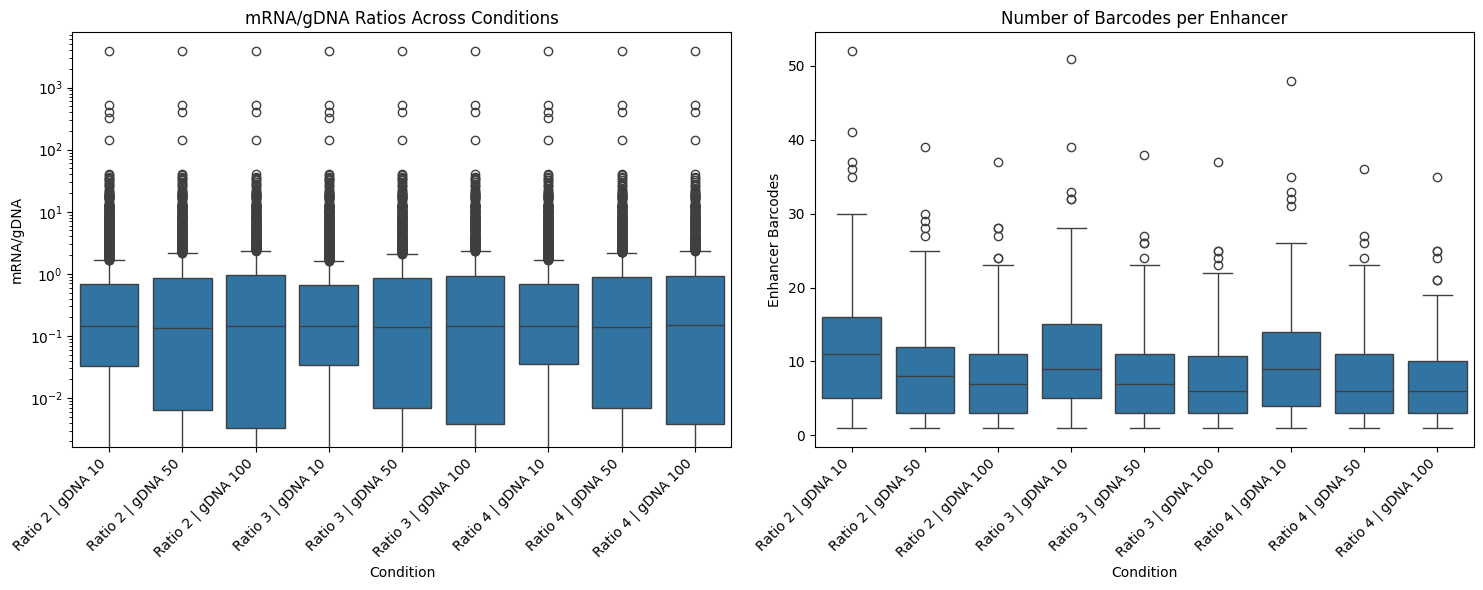

In [109]:
# Box-plot distribution of barcodes across enhancers and distribution of mRNA/gDNA ratios
enhancer_counts_dict = {}
mRNA_gDNA_ratios = {}

for (ratio_thresh, total_gDNA_thresh), df in final.items():
    merged_df = pd.merge(barcode_counts, df)
    merged_df.drop('nonzero_replicates', axis=1, inplace=True)
    enhancer_counts_dict[(ratio_thresh, total_gDNA_thresh)] = merged_df['Enhancer'].value_counts()
    mRNA_gDNA_ratios[(ratio_thresh, total_gDNA_thresh)] = merged_df['mRNA/gDNA']

mRNA_gDNA_df = pd.DataFrame([
    {'Condition': f'Ratio {rt} | gDNA {gd}', 'mRNA/gDNA': value}
    for (rt, gd), ratios in mRNA_gDNA_ratios.items()
    for value in ratios
])

enhancer_counts_df = pd.DataFrame([
    {'Condition': f'Ratio {rt} | gDNA {gd}', 'Enhancer Barcodes': count}
    for (rt, gd), counts in enhancer_counts_dict.items()
    for count in counts
])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='Condition', y='mRNA/gDNA', data=mRNA_gDNA_df, ax=axes[0])
axes[0].set_title("mRNA/gDNA Ratios Across Conditions")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_yscale('log')

sns.boxplot(x='Condition', y='Enhancer Barcodes', data=enhancer_counts_df, ax=axes[1])
axes[1].set_title("Number of Barcodes per Enhancer")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

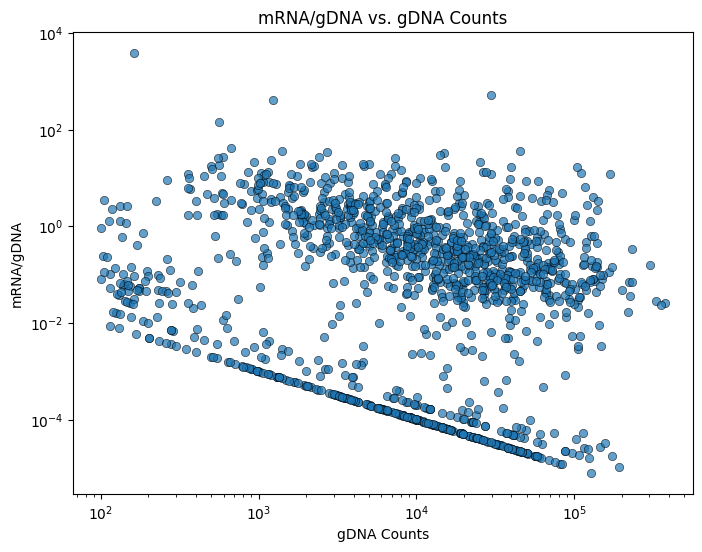

In [7]:
# plot between gDNA_Counts and mRNA/gDNA
df = final[(2, 100)].copy()
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, 
    x="gDNA_Counts", 
    y="mRNA/gDNA",
    edgecolor="black",
    alpha=0.7
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("gDNA Counts")
plt.ylabel("mRNA/gDNA")
plt.title("mRNA/gDNA vs. gDNA Counts")
plt.show()

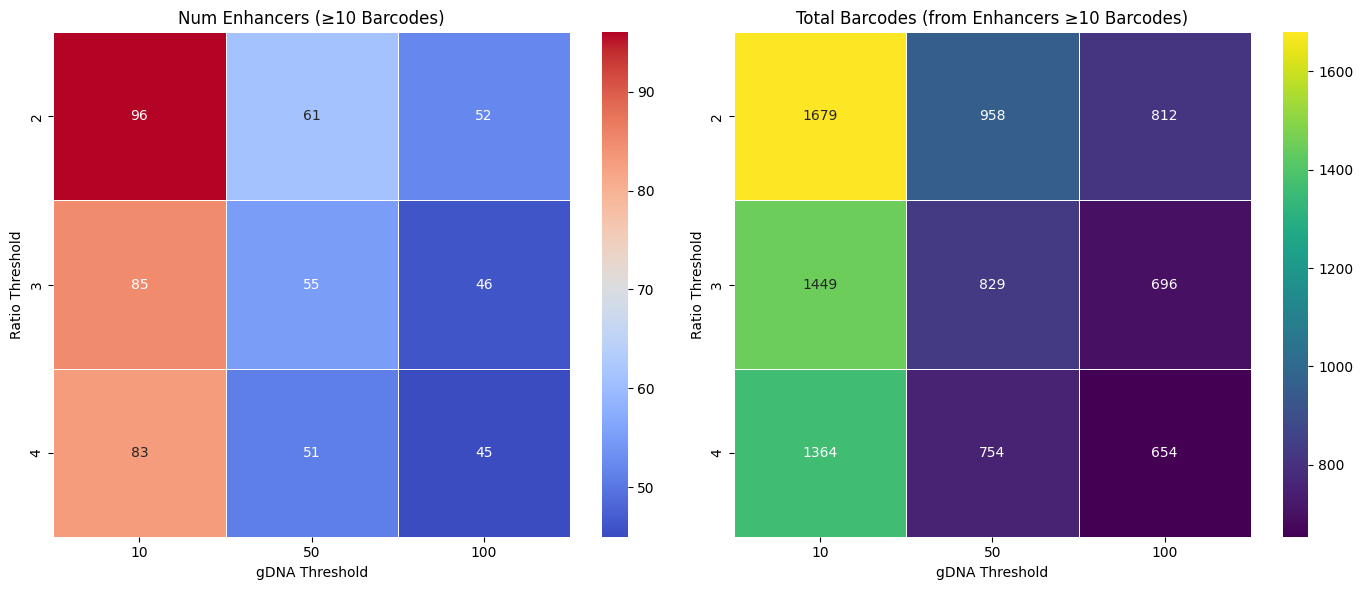

In [238]:
# what if we filter to keep only enhancers with more than 10 barcodes?

num_barcode_filter = 10
enhancer_counts_dict = {}

for (ratio_thresh, total_gDNA_thresh), df in final.items():
    merged_df = pd.merge(barcode_counts, df)
    merged_df.drop('nonzero_replicates', axis=1, inplace=True)
    enhancer_counts_dict[(ratio_thresh, total_gDNA_thresh)] = merged_df['Enhancer'].value_counts()

enhancer_summary = {}
total_barcodes_summary = {}

for (ratio_thresh, total_gDNA_thresh), counts in enhancer_counts_dict.items():
    # filter to keep only enhancers with ≥ num_barcode_filter barcodes
    filtered_counts = counts[counts >= num_barcode_filter]
    
    num_enhancers = filtered_counts.count()  # number of enhancers meeting threshold
    total_barcodes = filtered_counts.sum()   # Total number of barcodes meeting threshold

    condition_name = f"Ratio_{ratio_thresh}/gDNA_{total_gDNA_thresh}"
    enhancer_summary[condition_name] = num_enhancers
    total_barcodes_summary[condition_name] = total_barcodes

enhancer_summary_df = pd.DataFrame.from_dict(enhancer_summary, orient='index', columns=['Num_Enhancers'])
total_barcodes_df = pd.DataFrame.from_dict(total_barcodes_summary, orient='index', columns=['Total_Barcodes'])

summary_df = enhancer_summary_df.join(total_barcodes_df)
summary_df.index.name = 'Condition'
summary_df.reset_index(inplace=True)

summary_df[['Ratio', 'gDNA']] = summary_df['Condition'].str.extract(r'Ratio_(\d+)/gDNA_(\d+)')
summary_df.drop(columns=['Condition'], inplace=True)
summary_df = summary_df.astype({'Ratio': int, 'gDNA': int})

heatmap_num_enhancers = summary_df.pivot(index='Ratio', columns='gDNA', values='Num_Enhancers')
heatmap_total_barcodes = summary_df.pivot(index='Ratio', columns='gDNA', values='Total_Barcodes')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(heatmap_num_enhancers, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, ax=axes[0])
axes[0].set_title(f"Num Enhancers (≥{num_barcode_filter} Barcodes)")
axes[0].set_xlabel("gDNA Threshold")
axes[0].set_ylabel("Ratio Threshold")

sns.heatmap(heatmap_total_barcodes, annot=True, fmt="d", cmap="viridis", linewidths=0.5, ax=axes[1])
axes[1].set_title(f"Total Barcodes (from Enhancers ≥{num_barcode_filter} Barcodes)")
axes[1].set_xlabel("gDNA Threshold")
axes[1].set_ylabel("Ratio Threshold")

plt.tight_layout()
plt.show()

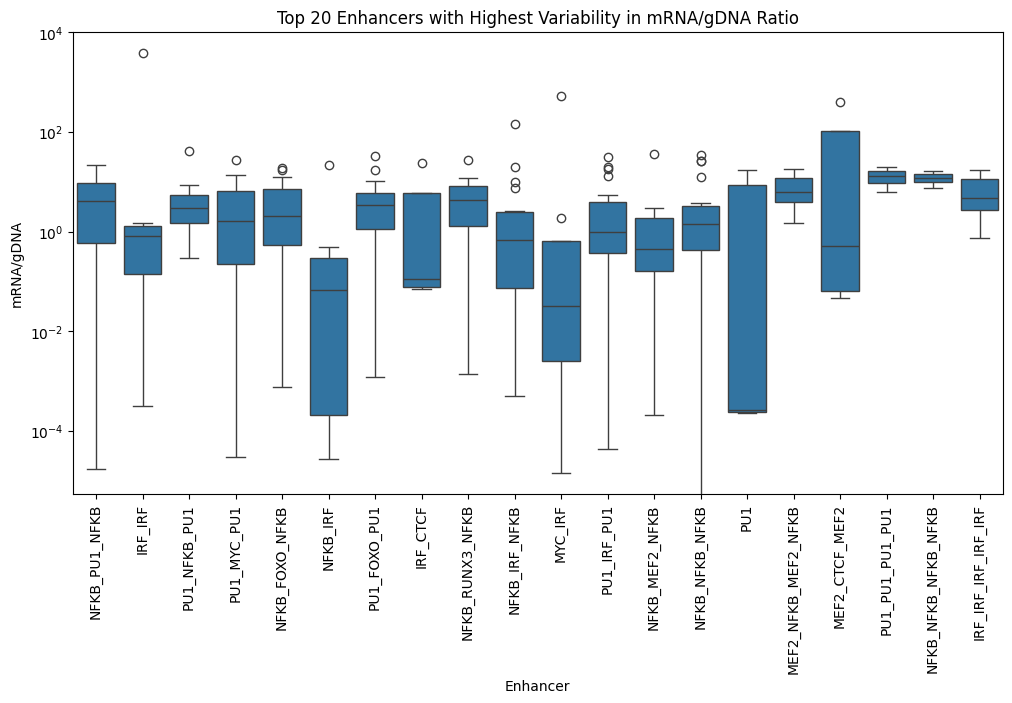

In [8]:
# top 20 enhancers with variability of mRNA/gDNA ratios
df = final[(2, 100)].copy()

enhancer_variability = df.groupby("Enhancer")["mRNA/gDNA"].var()

top_enhancers = enhancer_variability.nlargest(20).index

df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Top 20 Enhancers with Highest Variability in mRNA/gDNA Ratio")
plt.show()

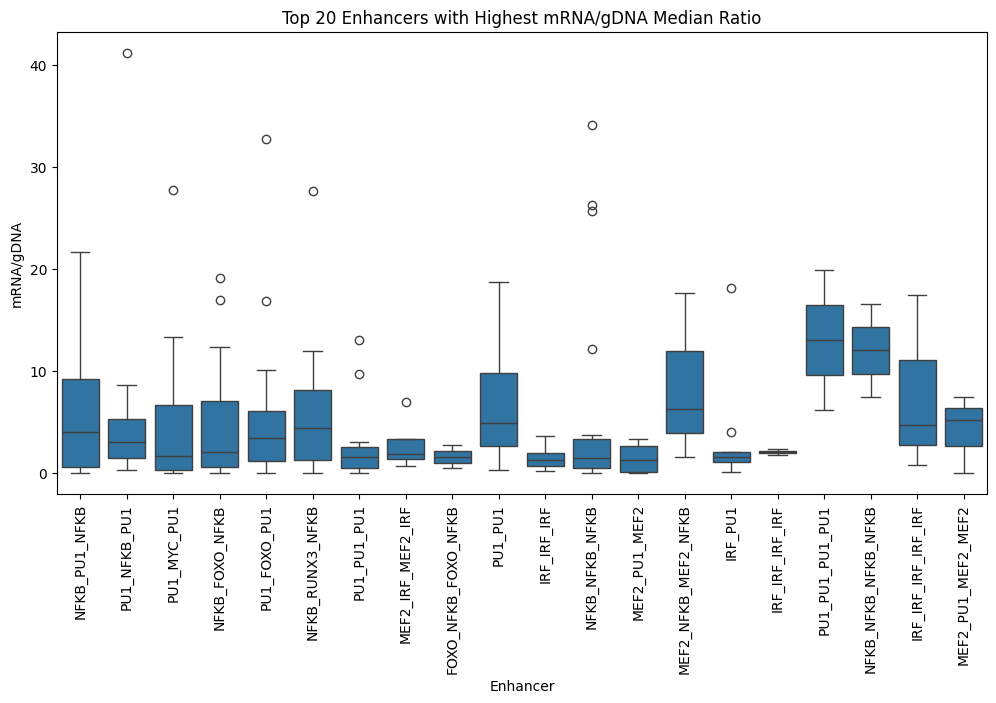

In [9]:
# top 20 enhancers with highest mRNA/gDNA median ratios

df = final[(2, 100)].copy()

enhancer_median = df.groupby("Enhancer")["mRNA/gDNA"].median()

top_enhancers = enhancer_median.nlargest(20).index

df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
# plt.yscale("log")
plt.title("Top 20 Enhancers with Highest mRNA/gDNA Median Ratio")
plt.show()

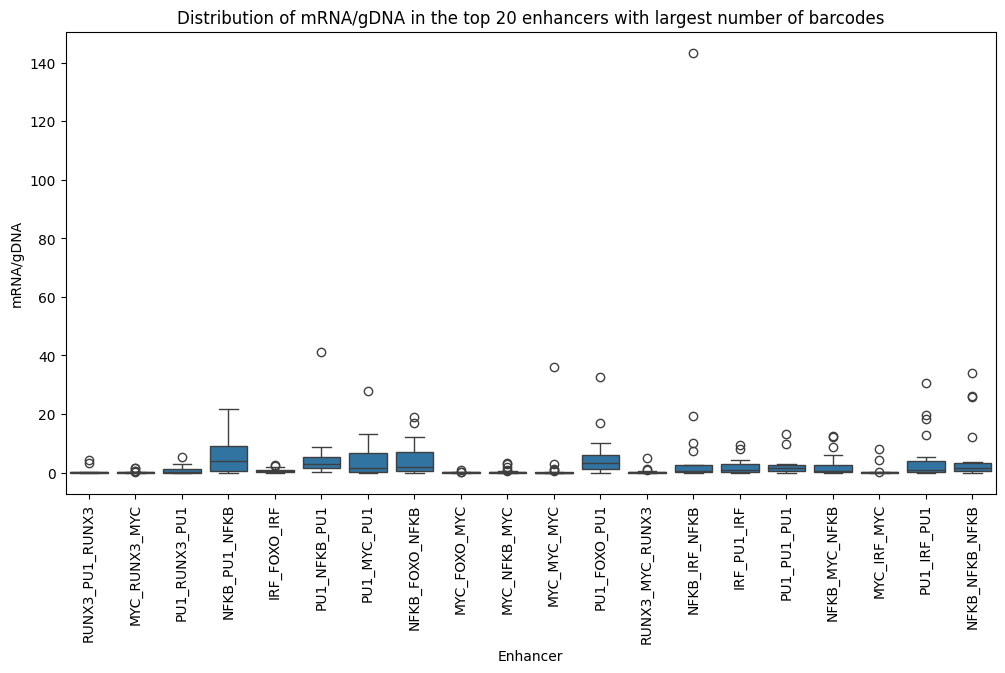

In [10]:
# mRNA/gDNA distribution of the top 20 enhancers with highest number of barcodes
df = final[(2, 100)].copy()

top_enhancers = df["Enhancer"].value_counts().nlargest(20).index

# Filter the dataframe for these top enhancers
df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
# plt.yscale("log")
plt.title("Distribution of mRNA/gDNA in the top 20 enhancers with largest number of barcodes")
plt.show()

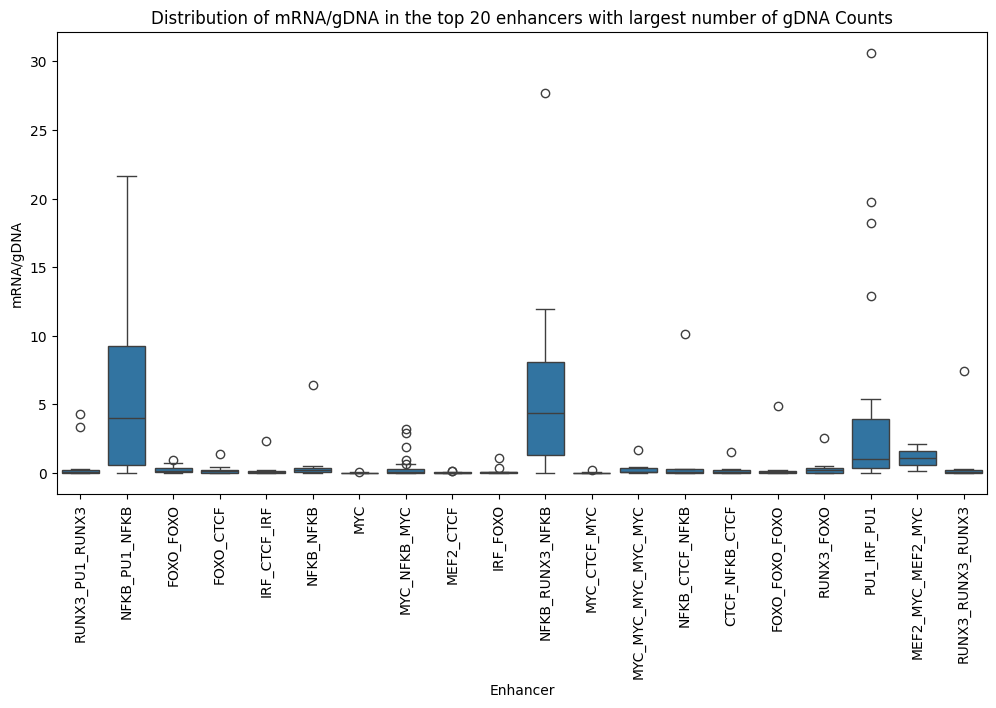

In [11]:
# mRNA/gDNA distribution of the top 20 enhancers with highest number of gDNA Counts
df = final[(2, 100)].copy()

top_enhancers = df.nlargest(20, "gDNA_Counts")["Enhancer"]

# Filter the dataframe for these top enhancers
df_top = df[df["Enhancer"].isin(top_enhancers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="Enhancer", y="mRNA/gDNA", data=df_top)
plt.xticks(rotation=90)
# plt.yscale("log")
plt.title("Distribution of mRNA/gDNA in the top 20 enhancers with largest number of gDNA Counts")
plt.show()

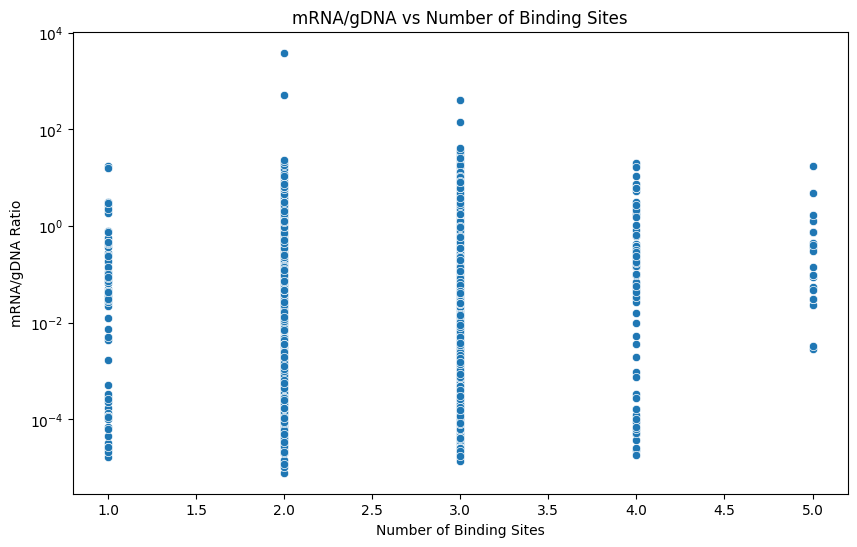

/tmp/SLURM_1240372/ipykernel_480267/1108217640.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_mrna_gdna.index, y=median_mrna_gdna.values, palette="viridis")


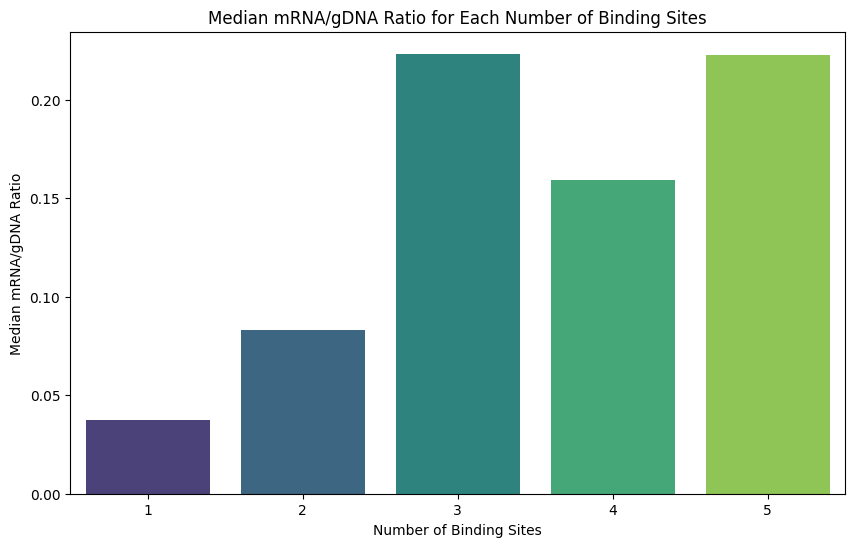

In [12]:
# categorize enhancers to how many binding sites they have and check mRNA/gDNA. 
# Usually, the more binding sites, the more we should expect to have a higher mRNA/gDNA ratio

df = final[(2, 100)].copy()
df['Number of Binding Sites'] = df['Enhancer'].apply(lambda x: x.count('_') + 1)
median_mrna_gdna = df.groupby("Number of Binding Sites")["mRNA/gDNA"].median()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Number of Binding Sites", y="mRNA/gDNA", data=df)
plt.title("mRNA/gDNA vs Number of Binding Sites")
plt.xlabel("Number of Binding Sites")
plt.ylabel("mRNA/gDNA Ratio")
plt.yscale('log')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=median_mrna_gdna.index, y=median_mrna_gdna.values, palette="viridis")
plt.title("Median mRNA/gDNA Ratio for Each Number of Binding Sites")
plt.xlabel("Number of Binding Sites")
plt.ylabel("Median mRNA/gDNA Ratio")
plt.show()

/tmp/SLURM_1240372/ipykernel_480267/3397971670.py:3: FutureWarning: The provided callable <function median at 0x7f20d4149d00> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  pivot_table = df.pivot_table(index="Enhancer", values="mRNA/gDNA", aggfunc=np.median).sort_values(by="mRNA/gDNA", ascending=True)


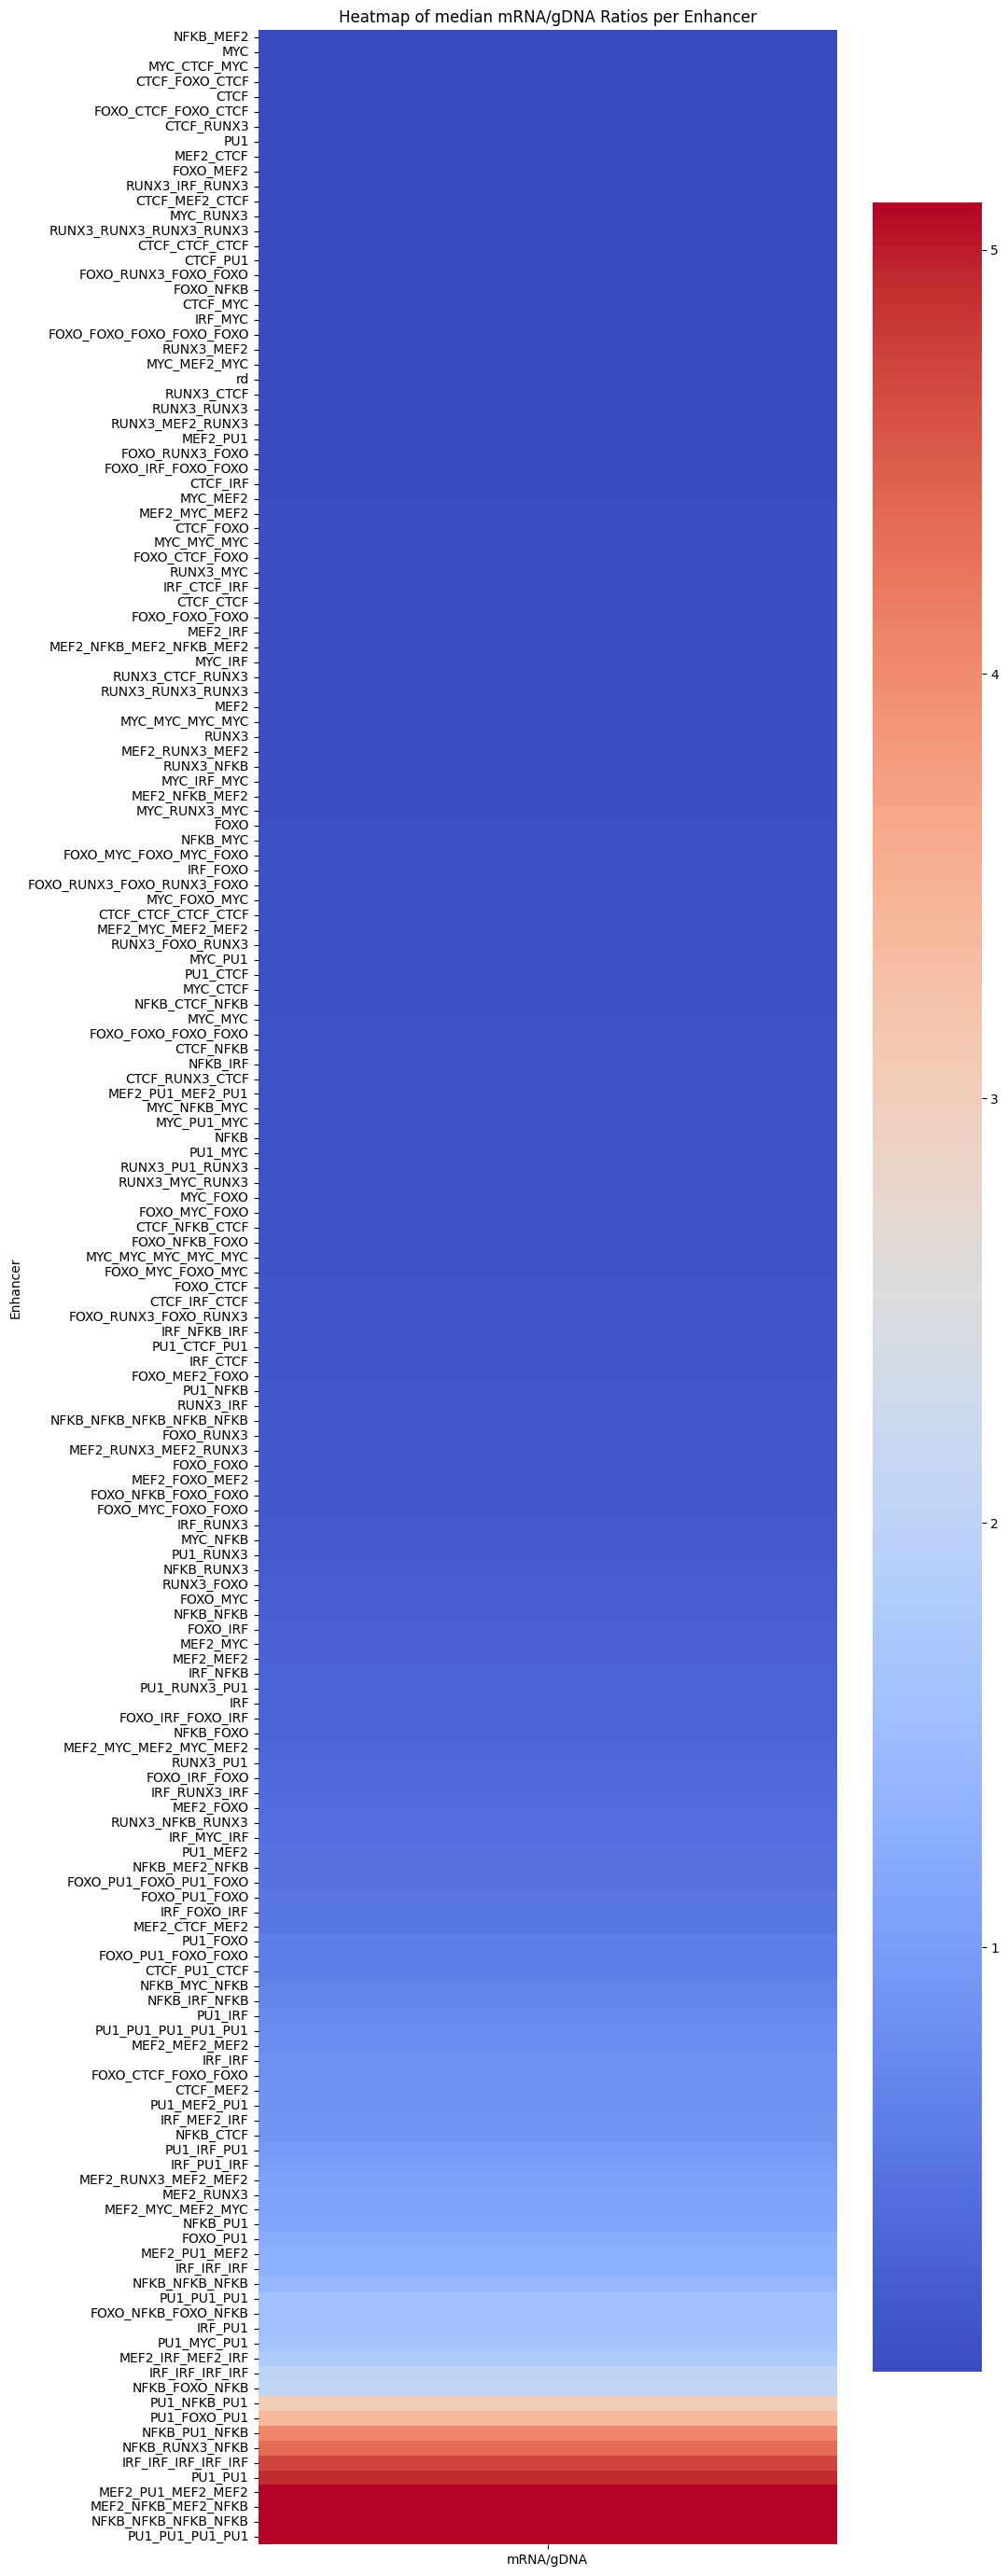

In [13]:
# heatmap for all enhancers' mRNA/gDNA ratios
df = final[(2, 100)].copy()
pivot_table = df.pivot_table(index="Enhancer", values="mRNA/gDNA", aggfunc=np.median).sort_values(by="mRNA/gDNA", ascending=True)

plt.figure(figsize=(10, 35))
sns.heatmap(pivot_table, cmap="coolwarm", robust=True)
plt.title("Heatmap of median mRNA/gDNA Ratios per Enhancer")
plt.show()

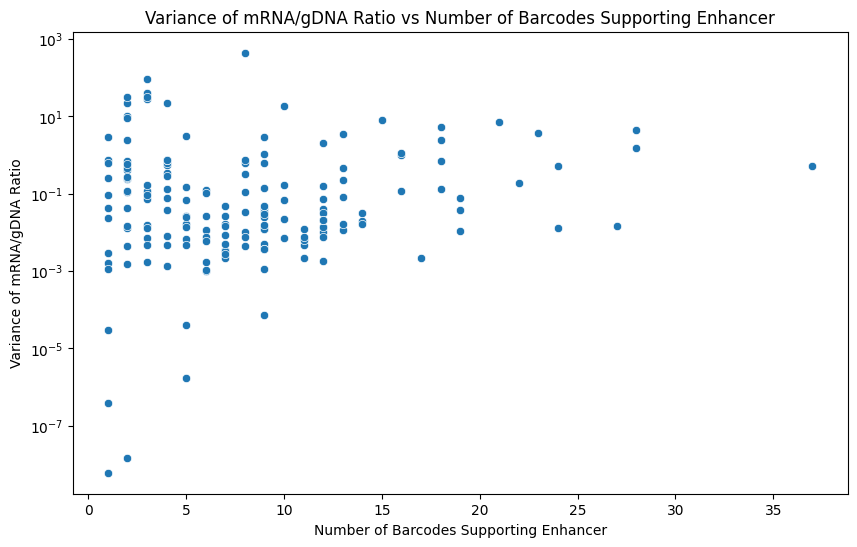

In [25]:
df = final[(2, 100)]
df = pd.merge(df, barcode_counts)
df.drop('nonzero_replicates', axis=1, inplace=True)
enhancer_sums = df.groupby("Enhancer")[["gDNA_rep1", "gDNA_rep2", "gDNA_rep3", "gDNA_rep4", "gDNA_rep5",
                                        "mRNA_rep1", "mRNA_rep2", "mRNA_rep3", "mRNA_rep4", "mRNA_rep5"]].sum()

ratios_list = []
for enhancer, row in enhancer_sums.iterrows():
    enhancer_ratios = []
    for i in range(1, 6):
        gDNA = row[f"gDNA_rep{i}"]
        mRNA = row[f"mRNA_rep{i}"]
        ratio = 0 if gDNA == 0 else mRNA / gDNA
        enhancer_ratios.append(ratio)
    
    ratios_list.append(enhancer_ratios)

ratios = pd.DataFrame(ratios_list, index=enhancer_sums.index, columns=[f"Ratio_rep{i}" for i in range(1, 6)])

enhancer_variance = ratios.var(axis=1)
variance_df = pd.DataFrame({"Enhancer": enhancer_variance.index, "Variance_mRNA/gDNA": enhancer_variance.values})

barcode_countss = df['Enhancer'].value_counts().reset_index()
barcode_countss.columns = ['Enhancer', 'Barcode Count']

variance_vs_barcodes = pd.merge(variance_df, barcode_countss, on="Enhancer")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Barcode Count', y='Variance_mRNA/gDNA', data=variance_vs_barcodes)
plt.title("Variance of mRNA/gDNA Ratio vs Number of Barcodes Supporting Enhancer")
plt.xlabel("Number of Barcodes Supporting Enhancer")
plt.ylabel("Variance of mRNA/gDNA Ratio")
plt.yscale('log')
plt.show()

In [50]:
df = final[(2, 100)].copy()
final_df = pd.merge(df, barcode_counts)
if 'nonzero_replicates' in final_df.columns:
 final_df.drop('nonzero_replicates', axis=1, inplace=True)
df_for_mpra = final_df.drop(columns=['gDNA_Counts', 'mRNA_Counts', 'mRNA/gDNA', 'Mapping_Counts', 'Mapping_Ratio'], axis=1)

enhancer_counts = df_for_mpra["Enhancer"].value_counts()
df_for_mpra = df_for_mpra[df_for_mpra["Enhancer"].isin(enhancer_counts[enhancer_counts >= 10].index)]
df_for_mpra = df_for_mpra[[col for col in df_for_mpra.columns if col != "Enhancer"] + ["Enhancer"]]

In [52]:
df_for_mpra.to_csv('df_for_mpra.tsv', sep='\t', index=False)

In [22]:
df = final[(2, 100)].copy()
final_df = pd.merge(df, barcode_counts)
if 'nonzero_replicates' in final_df.columns:
 final_df.drop('nonzero_replicates', axis=1, inplace=True)
df_for_mpra = final_df[['sequence', 'Enhancer']]

enhancer_counts = df_for_mpra["Enhancer"].value_counts()
df_for_mpra = df_for_mpra[df_for_mpra["Enhancer"].isin(enhancer_counts[enhancer_counts >= 10].index)]
df_for_mpra = df_for_mpra[[col for col in df_for_mpra.columns if col != "Enhancer"] + ["Enhancer"]]

df_for_mpra['Enhancer_barcode_count'] = df_for_mpra.groupby('Enhancer')['sequence'].transform('count')
df_for_mpra = df_for_mpra.drop(columns=['sequence'])
df_for_mpra = df_for_mpra.drop_duplicates(subset='Enhancer')
df_for_mpra

,Enhancer,Enhancer_barcode_count
2,RUNX3_PU1_RUNX3,19
4,RUNX3_IRF_RUNX3,11
6,MYC_FOXO,12
7,MYC_RUNX3_MYC,24
10,PU1_RUNX3_PU1,22
12,NFKB_PU1_NFKB,28
14,IRF_FOXO_IRF,16
17,FOXO_FOXO,12
22,NFKB,11
23,FOXO_CTCF,11


In [23]:
df_for_mpra.to_csv('enhancer_barcode_count.tsv',sep='\t', index=False)